# Model uczenia maszynowego do rozpoznawania rekombinacji w Brassica Napus
Wszystkie podstawowe pliki znajdowały się na serwerze.
Lokalizacja rekombinowanych fragmentów znajdowała sie w plikach w formacie .bed.
Po stworzeniu rozkładu długości można było zauważyć że większość fragmenów zanjduje sie w zakresie 0-2000pz, dlatego dłuższe sekwencje na ten moment odfiltrowałem a krótsze wyrównałem do 2000 i stworzyłem z nimi nowy plik .bed. 

Sekwecnje rekombinowane uzyskałem z genomu referencyjnego za pomocą bedtools przykład:  
bedtools getfasta -fi darmor10_chr.fa -bed fixed_locaction.bed -fo recombined.fasta  

Sekwencje nierekombinowane uzyskałem przez stworzenie pliku z lokalizacjami:  
bedtools random -l 2000 -n 1000 -g darmor10.genome > pliki_recomb-non_recomb/random_non_recomb.bed  
Następnie uzyłem bedtools intersect zeby sprawdzic czy na pewno fragmenty rekombinowane nie pokrywają się z tymi bez rekombinacji.
Tym samym narzędziem usunąłem fragmenty które znajdowały się w perycentromerach.  

Większość operacji na sekwencjach znajduję się w poniższym kodzie, jeśli do konkretnych plików został uzyty zewnętrzny skrypt lub narzędzię, będzię o tym informacja.



# Załadownie niezbędnych bibliotek

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn biopython shap itertools

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\marci\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import zlib
from collections import Counter
from Bio import SeqIO
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from itertools import product

## Tworzenie funkcji do odczytywanie sekwencji FASTA

parse_fasta_header - wyciąga chromosom, start oraz koniec sekwencji

load_fasta_to_dataframe - wczytuje dane oraz sekwencje z pliku oraz dodaje je do listy. Dodatkowo zmienna "max_records" ogranicza liczbe dodawanych sekwencji zeby mieć większą kontrole nad wielkością zbioru.


In [ ]:
def parse_fasta_header(header):
    chrom, coords = header.split(":")
    start, end = map(int, coords.split("-"))
    return chrom, int(start), int(end)

def load_fasta_to_dataframe(fasta_file, label, max_records=None):
    sequences = []
    for i, record in enumerate(SeqIO.parse(fasta_file, "fasta")):
        if max_records is not None and i >= max_records:
            break
        chrom, start, end = parse_fasta_header(record.id)
        sequences.append([str(record.seq), label, chrom, start, end])
    return sequences

In [ ]:
recombined = load_fasta_to_dataframe("recombined.fasta", 1)
non_recombined = load_fasta_to_dataframe("non_recombined_sequences_without_per.fasta", 0, max_records = 419)
data = recombined + non_recombined

## tworzenie dataframe
Stworzenie dataframe i dołączenie wcześniej pozyskanych danych.


W tym kroku zostaną wykorzystane pliki non_recombined_with_gene_distance.tsv, recombined_with_gene_distance.tsv, non_recombined_methylation_percent.bed, recombined_methylation_percent.bed.  

Na serwerze zostały mi udostępnione pliki z lokalizacją genów oraz procentem metylacji wybranych fragmentów.  
Wykorzystałem je aby dodać jako features minimalną odległość badanej sekwencji od genu oraz procent jej metylacji.
Do uzsykania informacji o lokalizacji genów i procencie metylacji wykorzystałem narzędzia taki jak: bedtools closest i bedtools map. do stworzenia pliku z obliczonym procentem metylacji wykorzystałem osobny skrypt (można zobaczyć go tutaj: https://github.com/marnap6/methylation_percent/blob/main/methylation/main.py).



In [ ]:
df = pd.DataFrame(data, columns=["sequence", "label", "chrom", "start", "end"])
#print(df.head)


## Dodanie informacji o odległości do genu

In [ ]:
#wczytanie danych z odległosciami
df_gene_dist_recombined = pd.read_csv("recombined_with_gene_distance.tsv", sep = "\t", header = None)
df_gene_dist_recombined.columns = ["chrom", "start", "end", "gene_chrom", "gene_start", "gene_end", "distance"]

df_gene_dist_non = pd.read_csv("non_recombined_with_gene_distance.tsv", sep="\t", header=None)
df_gene_dist_non.columns = ["chrom", "start", "end", "dummy1", "dummy2", "strand", "gene_chrom", "gene_start", "gene_end", "distance"]

#znalezienie minimalnej odleglosci i dodanie do df
gene_dist_recombined_min = df_gene_dist_recombined.groupby(["chrom", "start", "end"])["distance"].min().reset_index()
gene_dist_non_min = df_gene_dist_non.groupby(["chrom", "start", "end"])["distance"].min().reset_index()

df = df.merge(gene_dist_recombined_min, on=["chrom", "start", "end"], how="left")
df = df.merge(gene_dist_non_min, on=["chrom", "start", "end"], how="left", suffixes=('_recombined', '_non'))

df["min_gene_distance"] = df["distance_recombined"].combine_first(df["distance_non"])
df.drop(columns=["distance_recombined", "distance_non"], inplace=True)

In [ ]:
#print(df.head)

## Dodanie informacji o metylacji

In [ ]:
df_methyl_recombined = pd.read_csv("recombined_methylation_percent.bed", sep="\t")
df_methyl_recombined.columns = ["chrom", "start", "end", "percent_methylation"]

df_methyl_non = pd.read_csv("non_recombined_methylation_percent.bed", sep="\t")
df_methyl_non.columns = ["chrom", "start", "end", "percent_methylation"]

df_methyl_all = pd.concat([df_methyl_recombined, df_methyl_non], ignore_index=True)
df = df.merge(df_methyl_all, on=["chrom", "start", "end"], how="left")

In [ ]:
#print(df.head)

## Dodanie częstotliwości występowania k-merów jako ceche
Pozwala to na uchwycenie lokalnych wzorców nukleotydów, które mogą być charakterystyczne dla rekombinacji.  
W tym wypadku zliczane są 3-mery, ponieważ model miał z nimi najlepsze wyniki.

Stworzenie funkcji obliczającej występowanie k-merów oraz użycie jej na każdej sekwencji:

In [ ]:
def kmer_frequency(sequence, k=3):
    return dict(Counter(sequence[i:i+k] for i in range(len(sequence) - k + 1)))

#dodanie kolumny ze słownikami zawierającymi czestotliwosci k-merów
df["kmer_freq"] = df["sequence"].apply(lambda x: kmer_frequency(x, k=3))

Tworzy zbiór wszystkich k-merów, które występują w całym DataFrame, niezależnie od sekwencji.
Dzięki temu wiemy, które kolumny musimy utworzyć później jako cechy.

In [ ]:
all_kmers = sorted(set(k for km in df["kmer_freq"] for k in km))

Funkcja konwertuje słownk k_merow na osobne kolumny z pojedynczymi k-merami. Dzieki temu kazda sekwencja bedzie zawierała wartość dla wszystkich k-merów

In [ ]:
def kmer_to_dataframe(kmer_dict, all_kmers):
    return pd.Series({kmer: kmer_dict.get(kmer, 0) for kmer in all_kmers})

kmer_df = df["kmer_freq"].apply(lambda x: kmer_to_dataframe(x, all_kmers))

Dodanie kolumn z czestotliwoscia k-merow do glownego df oraz normalizacja do zakresu od 0 do 1.

In [ ]:
df = pd.concat([df, kmer_df], axis=1)

scaler = MinMaxScaler()
df[all_kmers] = scaler.fit_transform(df[all_kmers])

## Cechy globalne sekwencji – GC content i skew

Dla każdej sekwencji obliczamy:
- `gc_content` – procent nukleotydów G i C
- `gc_skew` – różnica między ilością G i C
- `at_skew` – różnica między ilością A i T

Te cechy mogą wskazywać na regiony genomu o specyficznych właściwościach biologicznych.

In [ ]:

def calculate_gc_content(sequence):
    gc_count = sum(1 for base in sequence if base in ('G', 'C'))
    return gc_count / len(sequence) if sequence else 0.0

def calculate_gc_skew(sequence):
    g = sequence.count('G')
    c = sequence.count('C')
    return (g - c) / (g + c) if (g + c) > 0 else 0.0

def calculate_at_skew(sequence):
    a = sequence.count('A')
    t = sequence.count('T')
    return (a - t) / (a + t) if (a + t) > 0 else 0.0

df["gc_content"] = df["sequence"].apply(calculate_gc_content)
df["gc_skew"] = df["sequence"].apply(calculate_gc_skew)
df["at_skew"] = df["sequence"].apply(calculate_at_skew)


## Średnie odległości między wystąpieniami wybranych k-merów

Obliczamy średnią odległość pomiędzy wystąpieniami wybranych 3-merów (`ATA`, `GAG`) i wszystkich możliwych 2-merów. 
To może być pomocne w wykrywaniu rozkładu motywów w sekwencji.

In [ ]:
def average_kmer_distance_general(sequence, kmer):
    positions = [i for i in range(len(sequence) - len(kmer) + 1) if sequence[i:i+len(kmer)] == kmer]
    return np.mean(np.diff(positions)) if len(positions) >= 2 else 0

df["ATA_avg_distance"] = df["sequence"].apply(lambda x: average_kmer_distance_general(x, "ATA"))
df["GAG_avg_distance"] = df["sequence"].apply(lambda x: average_kmer_distance_general(x, "GAG"))

# 2-mery
all_2mers = [''.join(p) for p in product("ATGC", repeat=2)]
for kmer in all_2mers:
    df[f"{kmer}_avg_distance"] = df["sequence"].apply(lambda x: average_kmer_distance_general(x, kmer))



## Kompresja sekwencji (LZ77)

Obliczamy współczynnik kompresji każdej sekwencji za pomocą algorytmu LZ77 (zlib). 
Im bardziej złożona (mniej powtarzalna) sekwencja, tym mniej się kompresuje – ta cecha może być wskaźnikiem złożoności regionu genomowego.

In [ ]:
def lz_compression_ratio(sequence):
    return len(zlib.compress(sequence.encode())) / len(sequence)

df["lz77_compression"] = df["sequence"].apply(lz_compression_ratio)

## Przygotowanie końcowego zbioru cech

Tworzymy ostateczną macierz cech, zawierającą wszystkie cechy numeryczne oraz etykietę `label`.
To dane, które posłużą do trenowania modelu.

In [ ]:
feature_columns = [
    *all_kmers,
    "gc_content", "gc_skew", "at_skew",
    "ATA_avg_distance", "GAG_avg_distance",
    *[f"{kmer}_avg_distance" for kmer in all_2mers],
    "lz77_compression", "min_gene_distance", "percent_methylation"
]

df_features = df[feature_columns + ["label"]].copy()


X = df_features.drop(columns=["label"])
y = df_features["label"]

## Trenowanie modelu Random Forest

Dzielimy dane na zbiór treningowy i testowy. Trenujemy model Random Forest z ustawionymi parametrami.
- `oob_score=True` – wykorzystujemy Out-Of-Bag do walidacji
- `class_weight="balanced"` – kompensujemy nierówną liczbę klas

Na końcu oceniamy model pod kątem dokładności, generujemy raport klasyfikacji oraz macierz pomyłek.

Dokładność modelu: 0.9244
OOB Error: 0.1181
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.87      0.92        87
           1       0.88      0.98      0.93        85

    accuracy                           0.92       172
   macro avg       0.93      0.93      0.92       172
weighted avg       0.93      0.92      0.92       172



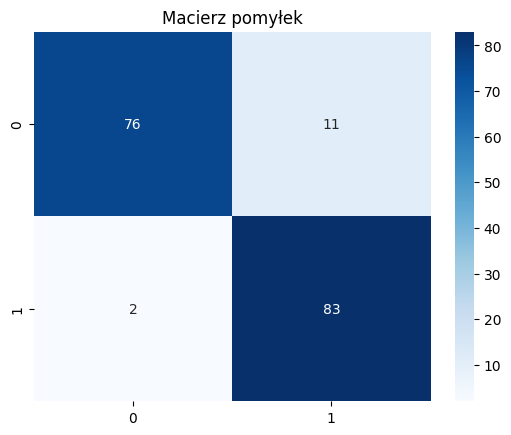

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



rf = RandomForestClassifier(
    n_estimators=50, max_depth=10, min_samples_leaf=5,
    oob_score=True, class_weight="balanced", random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Dokładność modelu: {accuracy_score(y_test, y_pred):.4f}")
print(f"OOB Error: {1 - rf.oob_score_:.4f}")
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Macierz pomyłek")
plt.show()


## Interpretacja modelu za pomocą SHAP

Obliczamy wartości SHAP dla testowych danych, aby zrozumieć, które cechy miały największy wpływ na klasyfikację. 
Wykresy pokazują:
- Najważniejsze cechy (barplot)
- Rozkład wartości SHAP (wpływ wartości na wynik)

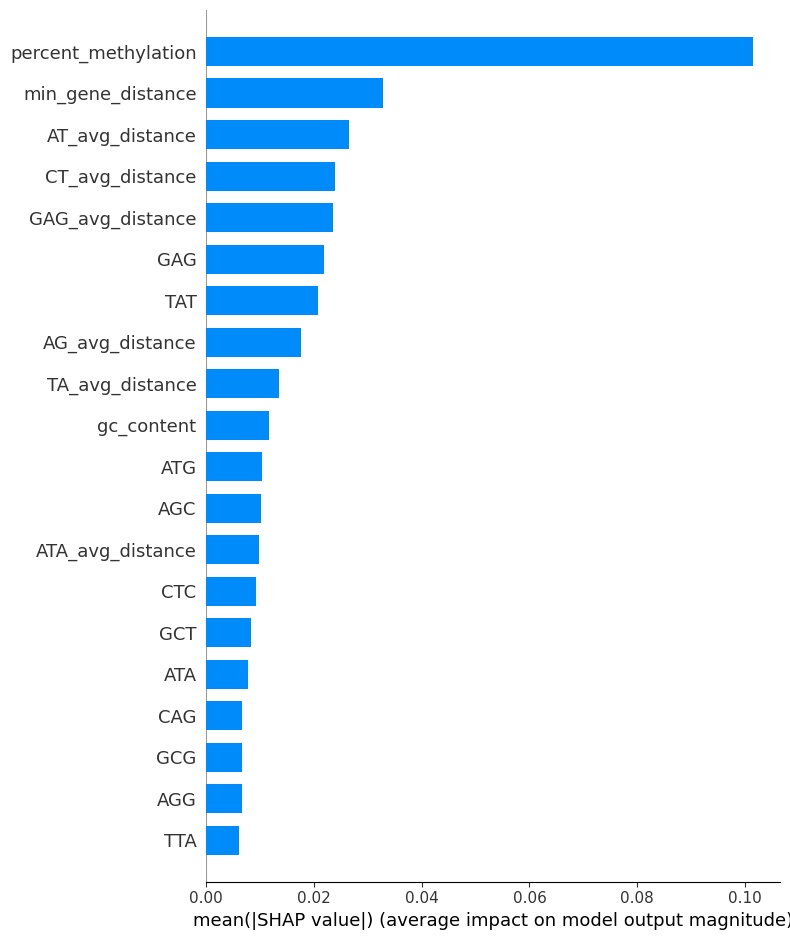

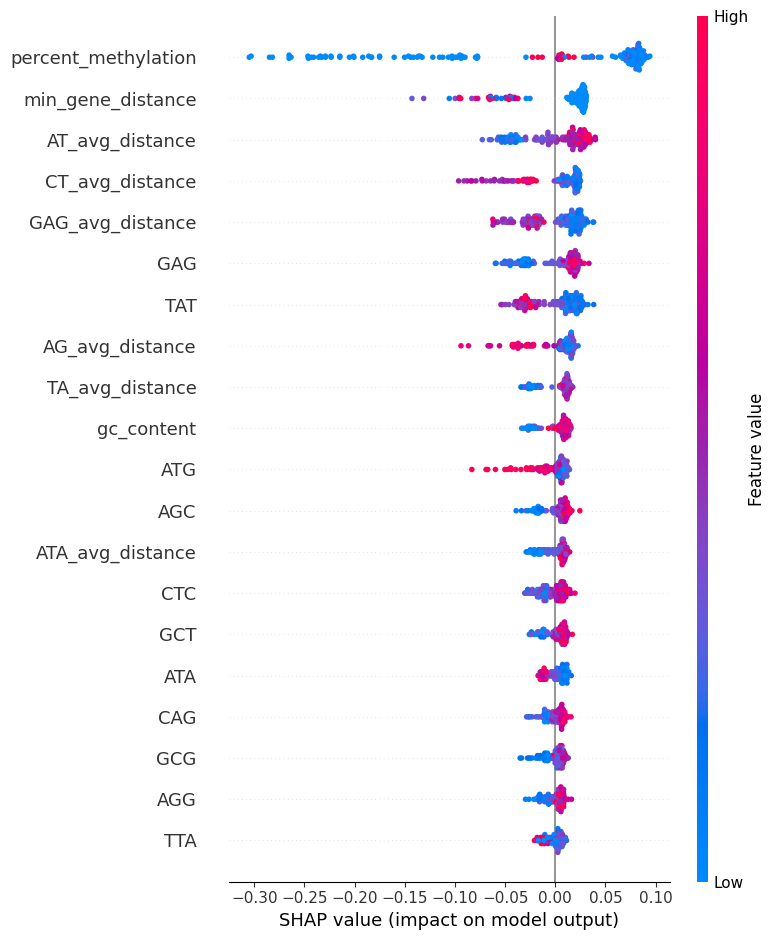

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap_values_selected = shap_values[:, :, 1]

shap.summary_plot(shap_values_selected, X_test, plot_type='bar')
shap.summary_plot(shap_values_selected, X_test)
#shap.dependence_plot("at_skew", shap_values_selected, X_test)


## Znaczenie cech
- `percent_methylation` - Niska metylacja częściej kojarzona jest z rekombinacją.
- `min_gene_distance` - Mała odległość fragmentu od najblizszego genu. Niska wartość wskazuje na to że rekombinacja często zachodzi w rejonach genów.
- `AT, CT` - Średni dystans miedzy tymi k-merami pokazuje że powtórzenia np "ATATAT" są powiązane z rekombinacją.


## Walidacja krzyżowa (5-krotna)

Obliczamy dokładność modelu na 5-fold cross-validation, aby upewnić się, że model nie jest przeuczony i generalizuje dobrze.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print(f"Cross-val Accuracy (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-val Accuracy (5-fold): 0.8928 ± 0.0231


## Analiza korelacji między zmiennymi

Wyświetlamy heatmapę korelacji między 25 najbardziej skorelowanymi cechami (względem etykiety). 
To może pomóc w lepszym zrozumieniu relacji między cechami i identyfikacji redundancji.


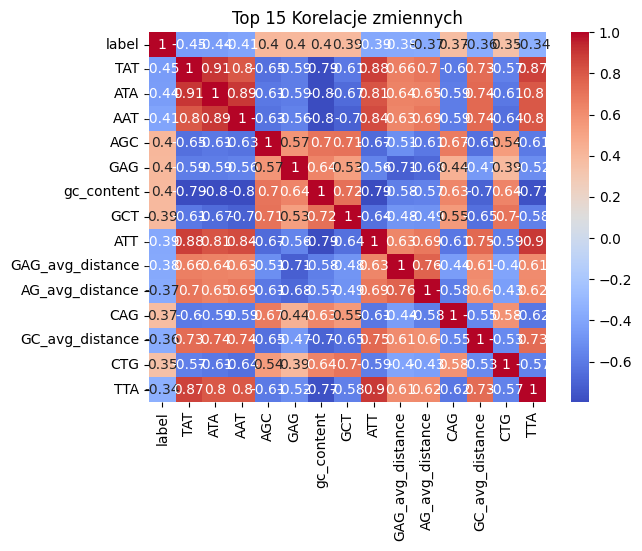

In [ ]:
top_corr = df_features.corr().abs()["label"].sort_values(ascending=False).head(15).index
sns.heatmap(df_features[top_corr].corr(), annot=True, cmap="coolwarm")
plt.title("Top 15 Korelacje zmiennych")
plt.show()

# Podsumowanie

- Model Random Forest osiąga dokładność ~92% i dobrze radzi sobie z klasyfikacją sekwencji rekombinowanych.
- SHAP pokazał, że istotnymi cechami są m.in. `percent_methylation`, `min_gene_distance`, średnia odległość między k-merami (`AT`, `CT`, `GAG`).
- Analiza korelacji ujawnia powiązania pomiędzy cechami, co może być pomocne przy dalszej redukcji wymiaru.